In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Import

In [36]:
import os
import sys
import csv
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Фиксируем окружение

In [37]:
!pip freeze > requirements.txt

# Основные настройки

In [38]:
EPOCHS               = 5    # эпох на обучение
BATCH_SIZE           = 64   # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4 # скорость обучения
VAL_SPLIT            = 0.2  # 20% данных выделяем на тест

CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = 120  # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3    # у RGB 3 канала
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = os.path.join(os.getcwd(), 'input')     # директория с данными
PATH = os.path.join(os.getcwd(), 'working', 'car') # рабочая директория

In [40]:
# создаём рабочую директорию
os.makedirs(PATH, exist_ok=True)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Версии

In [41]:
print(os.listdir(DATA_PATH))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['.ipynb_checkpoints', 'test.zip', 'sample-submission.csv', 'train.csv', 'train.zip']
Python       : 3.7.13 (default, Mar 16 2022, 17:37:17) 
Numpy        : 1.21.5
Tensorflow   : 2.8.0
Keras        : 2.8.0


# EDA / Анализ данных

In [42]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample-submission.csv'))

In [43]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [45]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

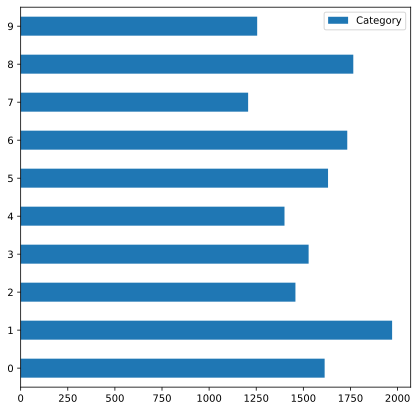

In [46]:
pd.DataFrame(train_df['Category'].value_counts(sort=False)).plot(kind='barh', figsize=(7, 7))

Распределение классов достаточно равномерное.

In [47]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(os.path.join(DATA_PATH, data_zip),"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


In [78]:
def veiw_random_images(random_image_paths, random_image_cat):
    for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(os.path.join(PATH, 'train', str(random_image_cat[index]), str(path)))
        plt.subplot(3,3, index+1)
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(im)
        plt.title('Class: ' + str(random_image_cat[index]))
    plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжать.

Пример картинок


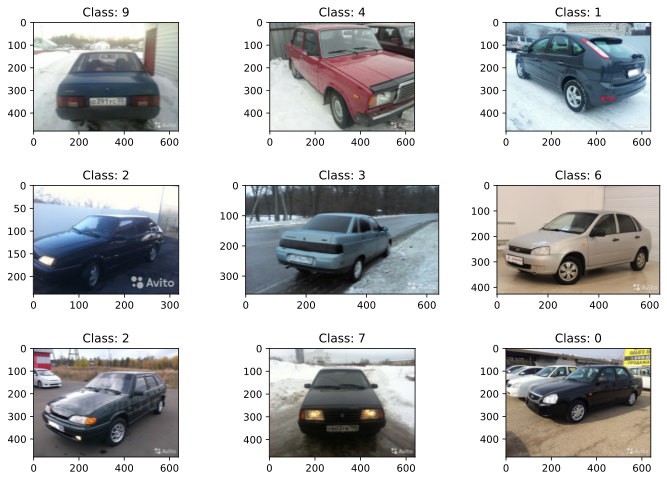

In [76]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Изображения вполне различимы. Имеют разный размер.

Посмотрим на изображения одного класса.

Пример картинок одного класса


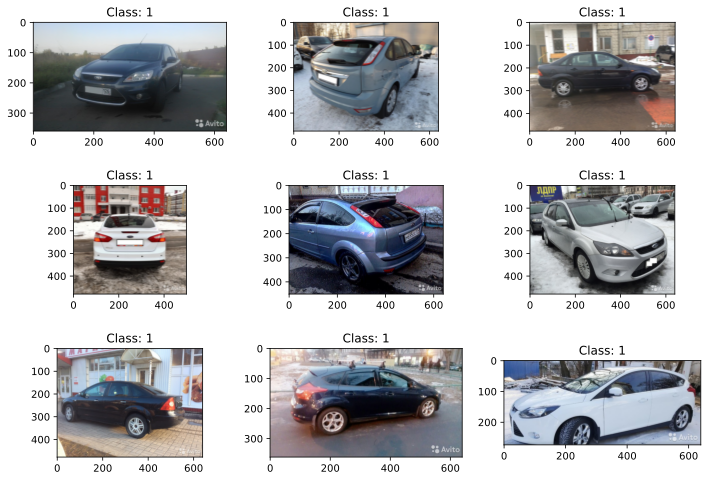

In [77]:
print('Пример картинок одного класса')
plt.figure(figsize=(12,8))

random_image = train_df.loc[train_df['Category'] == 1].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Очевидно что класс это модель автомобиля. 

# Подготовка данных

### Аугментация данных

Т.к. данных относительно не много, следует прибегнуть к аугментации данных.  
Чтобы экономить ресурсы железа создадим генератор, который будет подавать в модель изображения порциями.  
За аугментацию так же будет отвечать генератор.  

In [80]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    brightness_range=(0.2, 0.8),
    shear_range=0.2,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [81]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=os.path.join(PATH, 'test_upload'),
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Данные разбиты корректно: в каждой группе равное количество классов.

# Построение модели

### Загружаем предобученную сеть Xception:

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

Обучаем:

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# Рекомендация: попробуйте применить transfer learning с fine-tuning

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.6980
Epoch 00001: saving model to best_model.hdf5
207/207 [==============================] - 304s 1s/step - loss: 0.8705 - accuracy: 0.6980 - val_loss: 0.3195 - val_accuracy: 0.8798
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9284
Epoch 00002: saving model to best_model.hdf5
207/207 [==============================] - 302s 1s/step - loss: 0.2014 - accuracy: 0.9284 - val_loss: 0.2717 - val_accuracy: 0.9064
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9605
Epoch 00003: saving model to best_model.hdf5
207/207 [==============================] - 300s 1s/step - loss: 0.1078 - accuracy: 0.9605 - val_loss: 0.2517 - val_accuracy: 0.9154
Epoch 4/5
207/207 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9737
Epoch 00004: saving model to best_model.hdf5
207/207 [==============================] - 3

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 35s 934ms/step - loss: 0.3588 - accuracy: 0.9073
Accuracy: 90.73%


В Итоге точность нашей модели составила 93%. 
Учитывая что классов 10 - это Очень хороший результат!     
Посмотрим графики обучения:

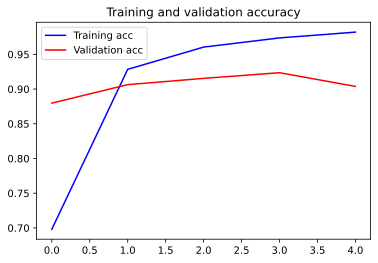

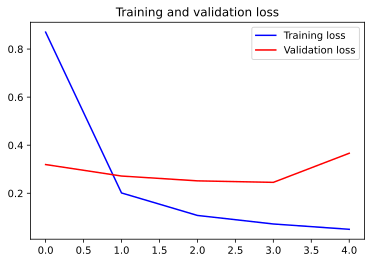

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

105/105 [==============================] - 42s 399ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,1
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!